In [45]:
#disable warnings
import warnings
warnings.filterwarnings("ignore") 

In [46]:
#stuff

# Purpose of this Notebook

In [111]:
#Number of reviews to put into data frame of good reviews. Set it to less than 0 if you want all of the good reviews to be processed
NUMB_OF_GOOD_REVIEWS = -1

#Number of reviews to put into data frame of bad reviews
NUMB_OF_BAD_REVIEWS = -1

#set to 1 if you want to reclean the dataframes, otherwise it will load data from a previous clean
#note cleaning takes 30 minutes on a pretty fast machine
CLEAN_DATAFRAME = 0

#used to seed the random state in parts of the NLP pipeline that need it
RANDOM_STATE=42

#the max number of processors to use in parallel for performing certain text processing steps in the NLP pipeline
N_JOBS = 8


#number of topics to generate in the document-term matrix created via LDA
NUMBER_OF_TOPICS=20

## Problem Statement

Product developers often want to know this about their products:

* For products that people don't like, what is it about the products they don't like? Maybe if we know this we could improve the product by fixing this unliked product features
* For products that people love, what is it about the products that result in people loving them? Maybe if we expanded on these loved features, we could get new customers or better retain current customers

## Proposed Solution

Perform topic modeling and that identifies the features of products that people love so that a product manager can have an idea of things that could be addressed to get more "likes" for the product.

Perform topic modeling that identifies the features of products that people don't like and somehow rank them so that a product manager can have a priority list of things that could be fixed to hopefully turn the disliked product into a liked product.


# Module Import

In [48]:
import datetime
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

#to speed up pandas operands
from pandarallel import pandarallel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



#gensim
from gensim import corpora, models, similarities, matutils



In [49]:
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'png'
%matplotlib inline 

# NLP Pipeline

This section of the notebook steps through the various stages of text processing starting with initial raw text read in from the CSV file and ends with the TFIDF-vectorized document-term matrix.


## Text Preprocessing

This diagram describes what is happening in the early parts of the document processing pipeline:

![text_preproc](./../Documents/Images/text_preprocessing.jpg)

**Deduplication**: Removing any rows in the original CSV that are duplicates. See code below for more on how duplicates were chosen

**NaN Removal**: Removed any row in the original CSV that contained one or more `NaN` (not a number) entries or where `HelpfulnessDenominator==0`.

**Cleaning**: Removed HTML and non-English words (according to NLTK's dictionary), removed punctuation, removed numbers, or space-delimited strings that contain numbers, converted what remains to lowercase

**Tokenization**: Converted the review, which exists as a single string, into separate strings, one string per word as identified by NLTK's `word_tokenize()`

**Lemmatization**: Convert each word into its equivalent form found in the dictionary

Reasons for all of this processing: To reduce the impact of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), and to not steer subsequent analysis steps to work on misspelled words.

For example the word "buying" and "bought" both appear in the review corpus. Both of these words are variations of the dictionary term "buy" and hence mean the same thing. If we were to allow all three terms to be analyzed it woud result in a matrix, where each document would be defined by three extra vector components when just one would suffice. 

The downside of this processing is that there are meaningful terms, that because they do not exist in the dictionary, are removed. For example the term [zubaz](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is removed from the corpus. This and other similar terms could be added back by manually expanding the set of terms in the NLTK dictionary, given more engineering time.


In [50]:
reviews_df = pd.read_csv("../Data/Reviews.csv")

In [51]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [52]:
reviews_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


According to the Kaggle description `HelpfulnessNumerator` should be less than or equal to `HelpfulnessDenominator`. So I will filter out any reviews that do not meet this specification.  Also, removing reviews where `HelpfulnessDenominator` is zero as this indicates a review that is not useful:

In [53]:
mask = (reviews_df["HelpfulnessNumerator"] <=  reviews_df["HelpfulnessDenominator"]) & (reviews_df["HelpfulnessDenominator"] > 0)
reviews_df[~mask].shape

(270054, 10)

There are few to remove so doing that now:

In [54]:
reviews_df = reviews_df[mask]

**Deduplication**: Are there any duplicate entries?

In [55]:
reviews_df.duplicated(subset=["UserId","ProfileName","Time","Text"],keep="first").value_counts()

False    209681
True      88719
dtype: int64

In [56]:
reviews_df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"],keep="first",inplace=True)

**NaN Removal**

In [57]:
reviews_df.dropna(inplace=True)

Speculative EDA: calculating a helpfulness metric in the hopes that it helps separate reviews.

In [58]:
reviews_df["helpful_rating"] = reviews_df["HelpfulnessNumerator"] / reviews_df["HelpfulnessDenominator"]

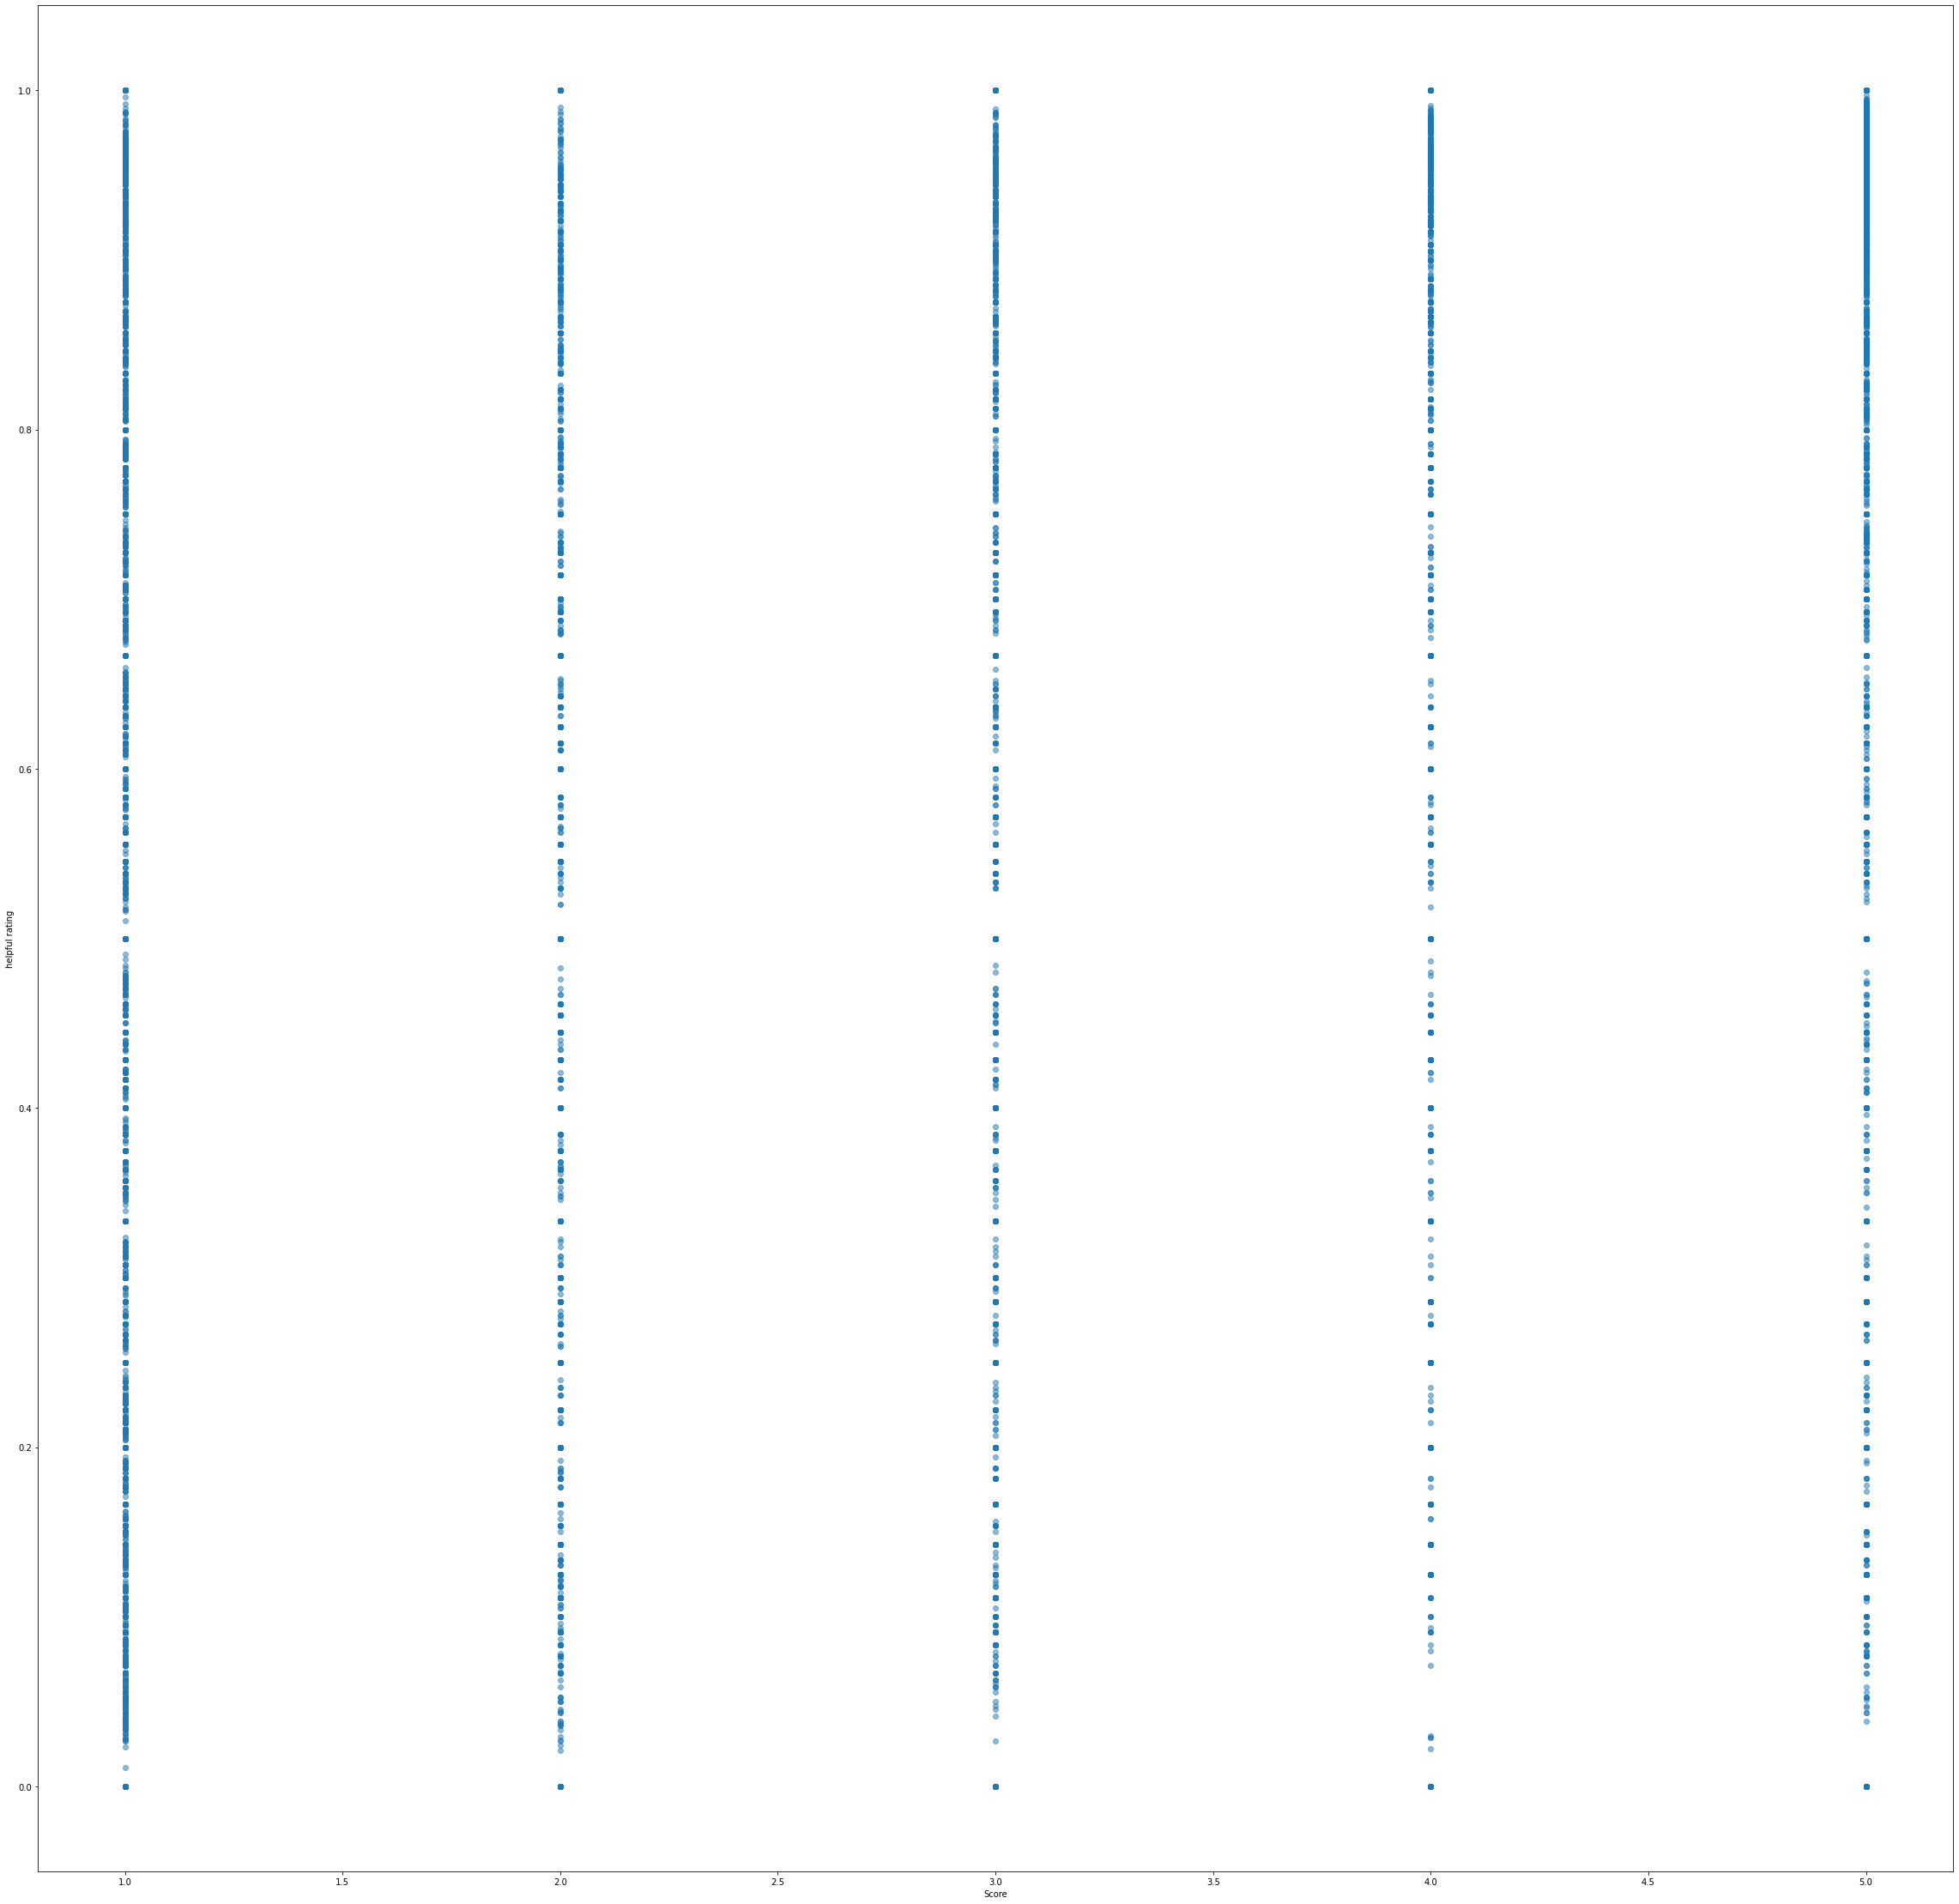

In [59]:
plt.figure(figsize=(40,40))
plt.scatter(reviews_df["Score"],reviews_df["helpful_rating"],alpha=0.5)
plt.xlabel("Score")
plt.ylabel("helpful rating")
plt.show();

This small bit of EDA does not yield any useful separation of reviews. Will not pursue anymore EDA for now.

Going to create a dataframe of bad reviews and one of good reviews to process separately. I remove reviews where "Score" == 3 because these do not indicate a call to action to either improve a bad product or point out a product that likely has nice features.



In [60]:
good_reviews_df = reviews_df[ reviews_df["Score"] >= 4 ]
bad_reviews_df = reviews_df[ reviews_df["Score"] <= 2 ]

In [61]:
if (NUMB_OF_GOOD_REVIEWS > good_reviews_df.shape[0]) or (NUMB_OF_GOOD_REVIEWS < 0):
    NUMB_OF_GOOD_REVIEWS = good_reviews_df.shape[0]


if (NUMB_OF_BAD_REVIEWS > bad_reviews_df.shape[0]) or (NUMB_OF_BAD_REVIEWS < 0):
    NUMB_OF_BAD_REVIEWS = bad_reviews_df.shape[0]

In [62]:
good_reviews_df = good_reviews_df[:(NUMB_OF_GOOD_REVIEWS + 1)]
bad_reviews_df = bad_reviews_df[:(NUMB_OF_BAD_REVIEWS + 1)]

In [63]:
#stuff = list(good_reviews_df.Text.head(NUMB_OF_DOCS1))

This is the function used to perform the **Cleaning** step described above.

In [64]:
#Removing HTML from the text
#stuff = [re.sub("<.*?>","",item) for item in stuff]

def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["Text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process



In [65]:
if CLEAN_DATAFRAME == 1:

    #TODO If you have time - convert it to a SQL query
    pandarallel.initialize()

    start_time = datetime.datetime.now()

    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(remove_html_punct,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(remove_html_punct,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
else:
    print("skipping cleaning the data frame.")

skipping cleaning the data frame.


In [66]:
good_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0


In [67]:
bad_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,1.0
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0.0
50,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,1,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",0.0
62,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,1,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,1.0


It takes a long time to perform this operation so going to save it to a pickle file if I ever need to rerun but don't need to do this cleaning step.

In [68]:
if CLEAN_DATAFRAME == 1:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)
    

In [69]:
good_reviews_df.reset_index(inplace=True)

Demonstrating here what the original review `Text` looks like compared to the `ProcessedText` at this point.

In [70]:
good_reviews_df.loc[0,"Text"]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [71]:
good_reviews_df.loc[0,"ProcessedText"]

'i have bought several of the vitality canned dog food and have found them all to be of good quality the product more like a stew than a meat and it better my is and she this product better than most'

In [72]:
bad_reviews_df.reset_index(inplace=True)

In [73]:
bad_reviews_df.loc[0,"Text"]

'If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.'

In [74]:
bad_reviews_df.loc[0,"ProcessedText"]

'if you are looking for the secret ingredient in i believe i have found it i got this in addition to the root beer extract i ordered which was good and made some cherry soda the flavor is very medicinal'

**Tokenization**

In [75]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["ProcessedText"])
    return temp_tokenized_txt


In [76]:
pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(tokenize_text,axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(tokenize_text,axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:09.094153


Here's what reviews look like after tokenization:

In [77]:
good_reviews_df.loc[0,"ProcessedText"]

['i',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'vitality',
 'canned',
 'dog',
 'food',
 'and',
 'have',
 'found',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'meat',
 'and',
 'it',
 'better',
 'my',
 'is',
 'and',
 'she',
 'this',
 'product',
 'better',
 'than',
 'most']

In [78]:
bad_reviews_df.loc[0,"ProcessedText"]

['if',
 'you',
 'are',
 'looking',
 'for',
 'the',
 'secret',
 'ingredient',
 'in',
 'i',
 'believe',
 'i',
 'have',
 'found',
 'it',
 'i',
 'got',
 'this',
 'in',
 'addition',
 'to',
 'the',
 'root',
 'beer',
 'extract',
 'i',
 'ordered',
 'which',
 'was',
 'good',
 'and',
 'made',
 'some',
 'cherry',
 'soda',
 'the',
 'flavor',
 'is',
 'very',
 'medicinal']

**Lemmatization**

In [79]:
wordNetLemmatizer = WordNetLemmatizer()

In [80]:
#lemmatize each word in stuff
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos




In [81]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["ProcessedText"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


Lemmatization takes a while (~10min) on my desktop. To save time I will save it off and only regenerate when I need to:

In [82]:
if CLEAN_DATAFRAME == 1:
    
    pandarallel.initialize()
    start_time = datetime.datetime.now()
    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lemmatize_it,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lemmatize_it,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews_lemmatized.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews_lemmatized.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews_lemmatized.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews_lemmatized.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)

lemmatizing to cut down on the size of the dimensions of the eventual vectorized word matrix without losing meaning of the text

In [83]:
good_reviews_df.loc[0,"ProcessedText"] 

'i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most'

In [84]:
bad_reviews_df.loc[0,"ProcessedText"] 

'if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal'

**Note**: In an earlier version of this notebook, I thought the analysis would be improved by only including the adjectives from the reviews in the downstream NLP pipeline. After looking through the resultant topic modeling, I realized it would be better to include the entire post-processed review into the pipeline. As it turns out the resultant topic-modeling yielded better results, i.e. the topics were more meaningful and were more easily related to the constituent reviews.

I leave the cell below to show how I went about removing the adjectives:

In [85]:
# I only want adjectives and adverbs sent to the vectorizer

def filter_pos(row,pos_abbrev=["JJ"]):
    """
    takes as input the following
    processes the "ProcessedText" column of a review data frame (see definition above)
    pos_abbrev = list of NLTK pos_tag() output parts of speech codes abbreviated to the first two characters
    
    """
#    print("pos_abbrev = ",pos_abbrev)

    
    if type(pos_abbrev) != type([]):
        print("post_abbrev must be a list of POS codes (1st 2 characters of the code only)")
        return 1
    
    temp_pos_filtered_doc = ""
    
    #pos_tag() works better if you pass the entire document to it as a tokenized list
    #it must be doing some sequence modeling under the hood to get the context of words so that it can
    #better ID parts of speech
        
    pos_result = pos_tag(row["ProcessedText"])
    
    for result_word, result_pos in pos_result:
        #print("tokenized word = ", word_tokenize(mylemword))
        #print("tokenized word pos = ", pos_tag(word_tokenize(mylemword))[0][1])
        
        for mypos in pos_abbrev:
            if (mypos in result_pos) :
                temp_pos_filtered_doc = temp_pos_filtered_doc + result_word + " "
            
    
    return temp_pos_filtered_doc.rstrip()


**TODO**: Run the notebook through with everything turned on as your final copy of the notebook.

Now just running `join()` on the tokenized reviews.

In [86]:
#stuff_pos_filtered = filter_pos(stuff_lemmatized,pos_abbrev=["JJ","RB"])
#stuff_pos_filtered
#stuff_pos_filtered = stuff_pos_filtered + filter_pos(stuff_lemmatized,"RB")

#Not doing this to see how LDA works when it's given all of the words of  each reive.
#pandarallel.initialize()
#start_time = datetime.datetime.now()
#good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(filter_pos,axis=1,pos_abbrev=["JJ","RB"])
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))

#pandarallel.initialize()
#start_time = datetime.datetime.now()
#good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
#bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))



In [87]:
good_reviews_df.loc[0,"ProcessedText"]

'i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most'

In [88]:
bad_reviews_df.loc[0,"ProcessedText"]

'if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal'

Final shape of bad and good reviews dataframes

In [89]:
good_reviews_df.shape

(152586, 13)

In [90]:
bad_reviews_df.shape

(40420, 13)

## Word Vectorization / Parsing

Will do the following here:
![tfidf_vectorize](../Documents/Images/tfidf_vectorization.jpg)

I did both document vectorization (i.e. converting each document into a vector, where each component of the vector is a number that represents some feature of the document) using `CountVectorizer` and `TfidfVectorizer`. I settled on `TfidfVectorizer` because it resulted in topics that made slightly better sense.


Why selected TFIDF?

The are a few words that are used very frequently in the corpus, like "buy":

```shell
(metis_linux_venv) :> grep -i buy Reviews.csv|wc -l
95872
(metis_linux_venv) :> grep -i bought Reviews.csv|wc -l
46267

```

In a straight word-count vectorizer documents vectors would weigh heavily in the direction of term, which could then lead to this being a topic. Given that this corpus overarching theme is about products purchased on Amazon, given it such weight doesn't seem warranted and does not add useful information beyond a certain point.

The TFIDF calculates the magnitude of the components for each word in the document according to this equation:

`TFIDF = (TermCountInDocument)/(TotalDocumentTerms) * log(TotalDocuments/DocumentsContainingTerm)`

So in count vectorized document-term matrix the word "buy" has much more influence on the topic assignment of a document than in the TFIDF vectorized document matrix. Here's an example:

Here's the "buy" vector component magnitude in the count vectorized document-term matrix for a few documents:

![count_vect_example](../Documents/Images/count_matrix_example.png)

Here's the "buy" vector component values for the same documents in the TFIDF vectorized document-term matrix:

![tfidf_vect_example](../Documents/Images/tfidf_matrix_example.png)

As you can see the vector component magnitudes for "buy" in the latter example are smaller because they are found in a large number of documents.

So the word "mold," which only shows up in 1541 documents, yet is a pretty significant (in human terms) topic now will have a correspondingly weighted mathematical significance (TFIDF shown below):
![tfidf_vect_example2](../Documents/Images/tfidf_matrix_example2.png)


In [91]:
vectorizer_gr = CountVectorizer(stop_words="english")
docTermMatrixCountVecGR = vectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])

tfidfvectorizer_gr = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFGR = tfidfvectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])


In [92]:
vectorizer_br = CountVectorizer(stop_words="english")
docTermMatrixCountVecBR = vectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

tfidfvectorizer_br = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFBR = tfidfvectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

In [93]:
len(vectorizer_gr.get_feature_names())

21926

In [94]:
docTermMatrixTFIDFBR.shape

(40420, 15183)

In [95]:
docTermMatrixTFIDFGR.shape

(152586, 21926)

In [96]:
len(vectorizer_br.get_feature_names())

15183

In [97]:
docTermMatrixCountVecGR.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [98]:
docTermMatrixCountVecGR.shape

(152586, 21926)

In [99]:
docTermMatrixCountVecBR.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [100]:
docTermMatrixCountVecBR.shape

(40420, 15183)

In [101]:
docTermMatrixTFIDFGR_df = pd.DataFrame(
    docTermMatrixTFIDFGR.toarray(),
    index=good_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_gr.get_feature_names()
)

In [165]:
docTermMatrixTFIDFGR_df.loc[docTermMatrixTFIDFGR_df["mold"]>0,["mold"]].head(5)

,mold
ProcessedText,
this packet of glaze be the secret to make those style fresh fruit i be about to make one for a pie auction at church after a friend that something should be you can make the most amazing and relatively fruit by bake a base it with uncooked fresh slice fruit then pour over the content of one of these they harden up at room temperature hold the fruit together so you can slice the tart and they let the beauty of the fruit show through also see this glaze use over to hold a fruit topping in place personally i do not like cheesecake too rich for me but a fruit glaze cheesecake be gorgeous i will admit to do this slice fruit and layer it on the cheesecake while still in the pan pour on the glaze let it set up and then remove the have a clear layer of fruit on top of the cheesecake or slice be nice but the best one i ever have use thin of that have be gently in sugar syrup before they be layer on the use a base of sponge cake bake in a shallow form but other base can be pate sucre a kind of pastry that be a bit like a sugar that work well in those flute you can also make in a muffin pan each mold with a layer of pie crust even commercial crust work though again i prefer pate sucre it it shape well and be more substantial and a good crumb just the muffin line with pate then pop them out and fill with fresh be great and pour over the glaze some people put a layer of patisserie which be a pastry cream like custard but with flour below the fruit and i happen to think these taste you get into bake this glaze be a on the shelf the be tapioca starch dextrose cream of tartar locust bean gum so if you be look to make a tofu cheesecake you can use this on top as well a use it for fruit with a nut crust base,0.065166
wow this product be very impressive i buy the blueberry and be with price and ship the powder instantly even in water just be a in a small glass of water for now and drink it down and it great but will add it to my and fruit next this product be so economical to fresh especially because there be no waste due to mold or overripe throw away i think you could add this to bake or unbaked a well excite to add more of the to my diet in this fast and easy way i definitely will be try the other soon,0.231527
i bake my first batch of these and be that they be so easy to make and taste so good then i them in the refrigerator since gluten free home bake good be notorious for mold i eat one straight out of the frig and it be great i guess the together after be a few i finish the batch one at a time out of the frig without any of them they be so good that way i bring myself to try them any other way our family be the area of gluten free eating for over the just keep get well a more be become aware of celiac disease i have an through that the gluten free we have have the pleasure of try,0.197134
the silver pearl dust be reasonably easy to use please use a light and careful touch i use this to decorate i use the tree mold and the be lovely and tasty,0.309105
i enjoy several of the baker breakfast banana nut pumpkin spice but this be my favorite not too sweet for my taste very satisfying and fill i heat in microwave for about and good to go great with coffee or tea i keep them in the freezer a they recommend you must do this a they can get mold otherwise and they always taste fresh and fine to me they be very nicely for the freezer also good in the toaster crispy be one of my favorite quick on hurried morning and sometimes i even enjoy them on a relaxed morning i buy these regularly and quality consistently good i recommend these highly,0.212081


In [102]:
#docTermMatrixTFIDFGR_df.head(3)

In [103]:

docTermMatrixCountVecGR_df = pd.DataFrame(docTermMatrixCountVecGR.toarray(), index=good_reviews_df["ProcessedText"], columns=vectorizer_gr.get_feature_names())

In [146]:
docTermMatrixCountVecGR_df.head(2)

,aa,aardvark,aback,abandon,abandoned,abb,abbey,abbot,abbreviation,abdomen,...,zodiac,zombie,zone,zoo,zoom,zooplankton,zoster,zowie,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
this be a confection that be around a few it be a light pillowy citrus gelatin with in this case and it be cut into tiny and then liberally coat with powdered sugar and it be a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you be familiar with the story of lion the witch and the this be the treat that into sell out his brother and to the witch,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
col_names = vectorizer_gr.get_feature_names()

In [148]:
thing = [stuff for stuff in col_names if stuff=="buy"]
thing

['buy']

```
In [102]: labels = [1, 2, 3]

In [103]: s.loc[s.index.intersection(labels)]
Out[103]: 
1    2
2    3
dtype: int64
```


In [166]:
docTermMatrixCountVecGR_df.loc[docTermMatrixCountVecGR_df["mold"]>0,["mold"]].head(5)

,mold
ProcessedText,
this packet of glaze be the secret to make those style fresh fruit i be about to make one for a pie auction at church after a friend that something should be you can make the most amazing and relatively fruit by bake a base it with uncooked fresh slice fruit then pour over the content of one of these they harden up at room temperature hold the fruit together so you can slice the tart and they let the beauty of the fruit show through also see this glaze use over to hold a fruit topping in place personally i do not like cheesecake too rich for me but a fruit glaze cheesecake be gorgeous i will admit to do this slice fruit and layer it on the cheesecake while still in the pan pour on the glaze let it set up and then remove the have a clear layer of fruit on top of the cheesecake or slice be nice but the best one i ever have use thin of that have be gently in sugar syrup before they be layer on the use a base of sponge cake bake in a shallow form but other base can be pate sucre a kind of pastry that be a bit like a sugar that work well in those flute you can also make in a muffin pan each mold with a layer of pie crust even commercial crust work though again i prefer pate sucre it it shape well and be more substantial and a good crumb just the muffin line with pate then pop them out and fill with fresh be great and pour over the glaze some people put a layer of patisserie which be a pastry cream like custard but with flour below the fruit and i happen to think these taste you get into bake this glaze be a on the shelf the be tapioca starch dextrose cream of tartar locust bean gum so if you be look to make a tofu cheesecake you can use this on top as well a use it for fruit with a nut crust base,1
wow this product be very impressive i buy the blueberry and be with price and ship the powder instantly even in water just be a in a small glass of water for now and drink it down and it great but will add it to my and fruit next this product be so economical to fresh especially because there be no waste due to mold or overripe throw away i think you could add this to bake or unbaked a well excite to add more of the to my diet in this fast and easy way i definitely will be try the other soon,1
i bake my first batch of these and be that they be so easy to make and taste so good then i them in the refrigerator since gluten free home bake good be notorious for mold i eat one straight out of the frig and it be great i guess the together after be a few i finish the batch one at a time out of the frig without any of them they be so good that way i bring myself to try them any other way our family be the area of gluten free eating for over the just keep get well a more be become aware of celiac disease i have an through that the gluten free we have have the pleasure of try,1
the silver pearl dust be reasonably easy to use please use a light and careful touch i use this to decorate i use the tree mold and the be lovely and tasty,1
i enjoy several of the baker breakfast banana nut pumpkin spice but this be my favorite not too sweet for my taste very satisfying and fill i heat in microwave for about and good to go great with coffee or tea i keep them in the freezer a they recommend you must do this a they can get mold otherwise and they always taste fresh and fine to me they be very nicely for the freezer also good in the toaster crispy be one of my favorite quick on hurried morning and sometimes i even enjoy them on a relaxed morning i buy these regularly and quality consistently good i recommend these highly,1


In [151]:
col_to_get = ["ProcessedText","buy"]

docTermMatrixCountVecGR_df.loc[docTermMatrixCountVecGR_df["buy"]>0,docTermMatrixCountVecGR_df.index.intersection(col_to_get)].head(10)

""
ProcessedText
i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most
instant oatmeal be great if you must have your oatmeal but can only scrape together two or three to prepare it there be no the fact however that even the best instant oatmeal be nowhere near as good a even a store brand of oatmeal preparation still the be as good a it for instant oatmeal even well than the organic i have try all the in the variety pack taste good it can be prepare in the microwave or by boil water so it be convenient in the extreme when time be an use of actual cane sugar instead of high fructose corn syrup me decide to buy this product real sugar well and be not as harmful a the other stuff one thing i do not like though be use of plus water plus heat should make a creamy tasty oatmeal without the need for guar gum but this be a convenience product maybe the guar gum be why after sit in the bowl a while the instant becomes too thick and gluey
get a free package of these with a bottle of bloody mary mix i buy from the seller and the advertising i try them and them with and we all them so here to buy more and there be no yet well now there be they be hot but not your mouth forever it a nice temp perfect for u
grape gummy be hard to find in my area in fact pretty much anyone i talk to about grape gummy they think lie so i buy these be a little bit big then the other and have kind of sour kick but nothing to strong i love grape flavor and these be pretty good there be another company that grape gummy that be a little bit well in my opinion but these be well worth it for the price i like to use the gummy in home make with flavored sport drink the salt in the sport drink for and the gummy be awesome frozen they be delicious
i know the product title molecular gastronomy but let that scare you off i have be look for this for a while now not for food science but for something more down to earth i use it to make my own coffee have to have my coffee blonde and sweet but the flavor be full of the bad of fat and honestly i hate to use i really think they be good for the body on the other hand i hate cold milk or cream because i like hot across this on one day and get the idea of make my own creamer i also buy milk powder and regular milk powder the milk be a little and than regular instant milk but do not dissolve good in cold water which be not a problem for hot coffee you will have to play with the i would not do just the heavy cream it make the coffee too rich also i think the powder be too expensive to just use on own i like of each flavoring i bough cocoa bean powder vanilla bean powder and caster superfine sugar i mix up small along with like cinnamon and nutmeg to make my own flavor if you you could use a fake powder instead i make up small that i store in jelly can i also use my little food processor to blend everything so the sugar be not and to the bottom let it settle for a bit before open the top stuff way well than the and it be fun to experiment and come up with your own i be go to try some essential next and see if i can get a good of the i be here take the time to experiment maybe you use any milk or add any it be up to you also would make great be sure other molecular people will be able to tell you more of what you can do with it and i be sure i will experiment with it in cook but the main reason i buy it be to make my own creamer and it work out great
we have three dog and all of them love this food we buy it specifically for one of our dog who food and it work great for him no more hot or tummy love that it right to our door with free shipping
my mix our vet a limited ingredient food this really her and she it i will always buy it from and free shipping
i first buy asparagus at an market and it be love at first bite hence when i saw these on the discount rack at the local i it out these be even good t

In [105]:
#docTermMatrixCountVecBR_df = pd.DataFrame(docTermMatrixCountVecBR.toarray(), index=bad_reviews_df["ProcessedText"], columns=vectorizer_br.get_feature_names())

In [106]:
#docTermMatrixCountVecBR_df.head(2)

In [107]:
docTermMatrixTFIDFBR_df = pd.DataFrame(
    docTermMatrixTFIDFBR.toarray(),
    index=bad_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_br.get_feature_names()
)

In [108]:
docTermMatrixTFIDFBR_df.head(3)

,aa,aback,abalone,abandon,abandoned,abandonment,abbey,abdomen,abdominal,aberrant,...,zipper,zippy,zombie,zone,zoo,zoology,zoom,zoonotic,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
my have be happily eat platinum for more than two i just get a new bag and the shape of the food be different they try the new food when i first put it in their bowl and now the bowl sit full and the will not touch the food similar relate to formula in the past unfortunately i now need to find a new food that my will eat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the candy be just red no flavor just plan and chewy i would never buy them again,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
#docTermMatrixCountVecGR_df.columns

In [110]:
#docTermMatrixCountVecBR_df.columns

In [112]:
LD_AllocatorGR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
LD_AllocatorBR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
LD_AllocatorTFIDFGR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
LD_AllocatorTFIDFBR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)


In [113]:
start_time = datetime.datetime.now()
LD_AllocatorGR.fit(docTermMatrixCountVecGR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:02:47.791366


In [114]:
start_time = datetime.datetime.now()
LD_AllocatorBR.fit(docTermMatrixCountVecBR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:00:26.531021


In [115]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFGR.fit(docTermMatrixTFIDFGR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:01:21.750899


In [116]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFBR.fit(docTermMatrixTFIDFBR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:00:14.662234


# Analysis of Reviews

We have vectorized and run it through LDA

## Topics via LDA

## LDA on "Good" Reviews

In [ ]:
#import pyLDAvis
#import pyLDAvis.sklearn

In [ ]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(LD_AllocatorGR, docTermMatrixCountVecGR, vectorizer_gr)

In [ ]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(LD_AllocatorBR, docTermMatrixCountVecBR, vectorizer_br)

Looking at these results (especially topic2 in the BR) that analyzing bi-grams would yields even more interpretable results. If I can get visualizations down I may opt to do bi=gram analysis or just put it in the to-do list

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

**TODO** You are picking the TFIDF vectorizer over the countvectorizer. Talk about why you are doing that.

In [ ]:
display_topics(LD_AllocatorGR, vectorizer_gr.get_feature_names(),10)

```
Topic  0
candy, like, taste, ginger, flavor, color, organic, good, product, licorice

Topic  1
tea, green, flavor, drink, taste, like, good, black, try, cup

Topic  2
oil, coconut, product, use, great, olive, good, quality, price, taste

Topic  3
food, cat, eat, dry, like, try, diet, good, weight, just

Topic  4
sugar, honey, like, taste, oatmeal, cinnamon, cracker, flavor, use, sweet

Topic  5
make, mix, free, gluten, use, bread, flour, bake, good, great

Topic  6
dog, food, treat, love, old, formula, good, like, small, eat

Topic  7
coffee, cup, good, like, taste, flavor, roast, try, strong, blend

Topic  8
sauce, like, good, flavor, use, hot, chicken, taste, make, try

Topic  9
use, work, make, hair, product, just, easy, plastic, time, like

Topic  10
butter, peanut, like, taste, powder, protein, bread, good, just, try

Topic  11
store, buy, local, day, price, time, grocery, try, just, work

Topic  12
flavor, love, coffee, try, great, vanilla, like, good, taste, best

Topic  13
rice, fat, low, high, protein, fiber, good, organic, sugar, product

Topic  14
water, add, make, use, little, just, cook, mix, cup, time

Topic  15
drink, water, taste, like, good, juice, try, flavor, energy, just

Topic  16
order, product, price, great, buy, good, box, time, shipping, ship

Topic  17
like, eat, just, good, taste, chip, bag, snack, popcorn, love

Topic  18
chocolate, bar, like, dark, taste, sweet, milk, gum, flavor, cocoa

Topic  19
eat, cereal, salt, good, great, love, breakfast, fruit, taste, healthy
```

In [ ]:
display_topics(LD_AllocatorTFIDFGR, tfidfvectorizer_gr.get_feature_names(),10)

In [ ]:
display_topics(LD_AllocatorBR, vectorizer_br.get_feature_names(),10)

```
Topic  0
price, buy, store, food, local, product, good, grocery, old, pay

Topic  1
chocolate, butter, bar, peanut, like, syrup, taste, cocoa, milk, flavor

Topic  2
bag, popcorn, day, just, come, plant, good, plastic, think, grow

Topic  3
eat, food, cat, just, tuna, litter, fish, try, salmon, good

Topic  4
order, product, company, receive, send, customer, time, service, say, use

Topic  5
product, list, organic, sugar, make, ingredient, corn, fat, high, label

Topic  6
drink, use, product, hair, try, work, energy, time, day, just

Topic  7
money, waste, use, make, try, buy, mix, like, bread, product

Topic  8
taste, like, flavor, water, drink, juice, try, just, coconut, artificial

Topic  9
sauce, taste, like, rice, good, just, flavor, try, hot, make

Topic  10
tea, green, flavor, taste, like, drink, vanilla, good, try, just

Topic  11
oil, gift, red, olive, basket, use, buy, make, good, just

Topic  12
coffee, cup, like, taste, good, flavor, try, just, buy, make

Topic  13
dog, food, make, chicken, eat, jerky, product, treat, meat, pet

Topic  14
salt, soup, candy, like, just, salty, box, eat, buy, taste

Topic  15
taste, like, sugar, good, sweet, just, buy, product, try, cereal

Topic  16
order, box, product, receive, item, ship, package, return, date, buy

Topic  17
like, taste, try, bad, smell, eat, just, good, chip, really

Topic  18
flavor, gum, like, product, just, cinnamon, good, chew, try, really

Topic  19
water, bottle, free, gluten, product, use, flour, milk, wheat, make
```

In [ ]:
display_topics(LD_AllocatorTFIDFBR, tfidfvectorizer_br.get_feature_names(),10)

## Visualization of Reviews

### PCA

#### Good Reviews
First let's check the quality of results of the topic generation by finding the reviews that scored best in the `docTopicMatrixGF_df`

In [ ]:
#docTopicMatrixGR = LD_AllocatorGR.transform(docTermMatrixCountVecGR)

In [ ]:
docTopicMatrixGR = LD_AllocatorTFIDFGR.transform(docTermMatrixTFIDFGR)

#LD_AllocatorTFIDFGR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)
#LD_AllocatorTFIDFBR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)

In [ ]:
docTopicMatrixGR_df = pd.DataFrame(docTopicMatrixGR).add_prefix("topic_")
docTopicMatrixGR_df.shape

In [ ]:
docTopicMatrixGR_df[["Summary","ProcessedText","Text","Score"]] = good_reviews_df[["Summary","ProcessedText","Text","Score"]]
docTopicMatrixGR_df.head()

In [ ]:
#find 5 reviews that score highest in topic_7
for review in docTopicMatrixGR_df.sort_values(by="topic_7",ascending=False).head(5)[["Summary","Score","Text"]].values:
    print(review,"\n")

From reading these 5 reviews they all seem to be discussion coffee either as a products that are very closely related to coffee.
So `topic_7` is the **coffee**.

In [ ]:
good_review_vocab = tfidfvectorizer_gr.get_feature_names()
wordTopicmatrixGR_df = pd.DataFrame(LD_AllocatorTFIDFGR.components_,columns=good_review_vocab).T.add_prefix("topic_")
wordTopicmatrixGR_df.head()

In [ ]:
word = (wordTopicmatrixGR_df.sort_values(by="topic_7",ascending=False).head(1))["topic_7"].index[0]

In [ ]:
word

In [ ]:
#LD_AllocatorTFIDFGR.components_.shape

In [ ]:
#topicXwordGBMatrix = LD_AllocatorTFIDFGR.components_

In [ ]:
#topicXwordGBMatrix

In [ ]:
pcaGR = PCA(n_components=2)
pcaGR.fit(docTopicMatrixGR)
docReducedTopicMatrixGR = pcaGR.transform(docTopicMatrixGR)

In [ ]:
docReducedTopicMatrixGR.shape

In [ ]:
docReducedTopicMatrixGR[0][0],docReducedTopicMatrixGR[0][1]

In [ ]:
#Color map used to color each document in the plot
TOPIC_COLORS={"topic_0":"red",
                 "topic_1":"orange",
                 "topic_2":"yellow",
                 "topic_3":"green",
                 "topic_4":"blue",
                 "topic_5":"indigo",
                 "topic_6":"violet",
                 "topic_7":"cyan",
                 "topic_8":"brown",
                 "topic_9":"white",
                 "topic_10":"gray",
                 "topic_11":"yellowgreen",
                 "topic_12":"skyblue",
                 "topic_13":"chartreuse",
                 "topic_14":"goldenrod",
                 "topic_15":"salmon",
                 "topic_16":"magenta",
                 "topic_17":"cornflowerblue",
                 "topic_18":"ivory",
                 "topic_19":"black"}

In [ ]:
def getcolor(row_index,basecolor,doc_topic_matrix_df):
    """
    This function takes a document located at `row_index` in the `doc_topic_matrix_df` and determines
    to which topic it belongs by finding the column with the max value at `row_index` in `doc_topic_matrix_df`
    It then uses `TOPIC_COLORS` to return the color associated with that topic
    """
    #assuming the first 20 columns are the topic weights
    global TOPIC_COLORS
    max_topic_name = doc_topic_matrix_df.iloc[:,:20].iloc[row_index].idxmax()
    
    if max_topic_name in TOPIC_COLORS.keys():
        return TOPIC_COLORS[max_topic_name]
    else:
        print("WARNING: Say topic = {} and did not expect to!".format(max_topic_name))
        return "black"
    

In [ ]:
def plot_PCA_2D2(DocTopic2DMatrix,DocTopicMatrix_df, word_topic_matrix_df, plot_name="pca_scatter_plot.png"):
    """
    Generates a 2-D scatter plot of the reviews.
    
    `DoctTopic2DMatrix` is an array of N documents where the columns in row i represent the (x,y) coordinates for that document (document i)
    
    Each plotted document is colored according to the topic (out of 20) to which it belongs and is
    colored according to the topic-to-color map defined in TOPIC_COLORS
    
    `plot_name`: file name of the plot (must end in png)
    
    """
    #TODO: Get it to work for any number of topics (mostly calc colors using the topic as the offset from a base color)
    global TOPIC_COLORS

    review_names = ["r"+str(numb) for numb in range(len(DocTopic2DMatrix))]
    review_ids = range(len(review_names))
    plotted_topics = []
    plt.figure(figsize=(20,20))
    for id in review_ids:
        color = getcolor(id,"#000000",DocTopicMatrix_df)
        for mykey in TOPIC_COLORS.keys():
            if color == TOPIC_COLORS[mykey]:
                #name = mykey
                #get word best associated with this topic and use that as the label for the point
                name = (word_topic_matrix_df.sort_values(by=mykey,ascending=False).head(1))[mykey].index[0]
        plt.scatter(DocTopic2DMatrix[id][0],DocTopic2DMatrix[id][1],c=color,label=name,edgecolors="gray",alpha=0.8)
        plotted_topics.append(name)
    
    plotted_topics = set(plotted_topics)
    plotted_topics = list(plotted_topics)
    #not needed as I don't use the raw `topic_<X>` monikers anymore
    #plotted_topics.sort(key=lambda x: int(x.split("_")[1]))
    plotted_topics.sort()
    plt.legend(plotted_topics)
    plt.savefig("../Documents/Images/{}".format(plot_name),dpi=400)


In [ ]:
review_subset_size = 7000

numb_of_good_reviews = docReducedTopicMatrixGR.shape[0]
selected_reviews = np.random.choice(numb_of_good_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixGR_sub = docReducedTopicMatrixGR[selected_reviews,:]


In [ ]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()
plot_PCA_2D2(docReducedTopicMatrixGR_sub, docTopicMatrixGR_df, wordTopicmatrixGR_df, "good_reviews_subset.png")
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

**TODO**
You ran the cluster on the whole set of bad reviews. Include that here and add some narration to it.

#### Bad Reviews
Now let's check the quality of results of the topic generation by finding the reviews that scored best in the `docTopicMatrixBR_df`

In [ ]:
docTopicMatrixBR = LD_AllocatorTFIDFBR.transform(docTermMatrixTFIDFBR)

In [ ]:
docTopicMatrixBR_df = pd.DataFrame(docTopicMatrixBR).add_prefix("topic_")
docTopicMatrixBR_df[["Summary","ProcessedText","Text","Score"]] = bad_reviews_df[["Summary","ProcessedText","Text","Score"]]
docTopicMatrixBR_df.head()

In [ ]:
#find 5 reviews that score highest in topic_7
for review in docTopicMatrixBR_df.sort_values(by="topic_0",ascending=False).head(5)[["Summary","Score","Text"]].values:
    print(review,"\n")

In [ ]:
bad_review_vocab = tfidfvectorizer_br.get_feature_names()
wordTopicmatrixBR_df = pd.DataFrame(LD_AllocatorTFIDFBR.components_,columns=bad_review_vocab).T.add_prefix("topic_")
wordTopicmatrixBR_df.head()

In [ ]:
(wordTopicmatrixBR_df.sort_values(by="topic_12",ascending=False).head(5))["topic_12"]

In [ ]:
pcaBR = PCA(n_components=2)
pcaBR.fit(docTopicMatrixBR)
docReducedTopicMatrixBR = pcaBR.transform(docTopicMatrixBR)

In [ ]:
review_subset_size = 7000

numb_of_bad_reviews = docReducedTopicMatrixBR.shape[0]
selected_reviews = np.random.choice(numb_of_bad_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixBR_sub = docReducedTopicMatrixBR[selected_reviews,:]


In [ ]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()
plot_PCA_2D2(docReducedTopicMatrixBR_sub, docTopicMatrixBR_df,wordTopicmatrixBR_df,"bad_reviews_subset.png")
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

**Caution**: Running the two cells below can take up to 12 hours to run. I'm protecting them with a option variable below.

In [ ]:
GENERATE_FULL_SCATTER_PLOT = 0

In [ ]:
if GENERATE_FULL_SCATTER_PLOT:
    start_time = datetime.datetime.now()
    plot_PCA_2D2(docReducedTopicMatrixBR, docTopicMatrixBR_df,"bad_reviews_full.png")
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))

In [ ]:
if GENERATE_FULL_SCATTER_PLOT:

    start_time = datetime.datetime.now()
    plot_PCA_2D2(docReducedTopicMatrixGR, docTopicMatrixGR_df,"good_reviews_full.png")
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))

## Component Selection Evaluation
In this section I will perform KMeans clustering of the good and bad reviews and generate a [scree plot](https://en.wikipedia.org/wiki/Scree_plot). The purpose of the scree plotting will be to determine if the number of topics chosen in the PCA analysis performed above explains an adequate amount of variance in the respective reviews.

### Good Review Scree Plot Analysis

In [ ]:
docTermMatrixTFIDFBR.shape

In [ ]:
#Using the TFIDF vectorized document term matrix as the data set
pcaGR40 = TruncatedSVD(n_components=500)
pcaGR40.fit(docTermMatrixTFIDFGR)
plt.figure(figsize=(20,20))
plt.plot(pcaGR40.explained_variance_ratio_)
plt.xlabel("Topic Number",fontsize=16)
plt.ylabel("Percent Explained Variance",fontsize=16)
plt.show();

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(np.cumsum(pcaGR40.explained_variance_ratio_))
plt.xlabel("Number of Topics",fontsize=16)
plt.ylabel("Cumulative Percent of Explained Variance",fontsize=16)
plt.show();

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

### Bad Review Scree Plot Analysis

In [ ]:
#Using the TFIDF vectorized document term matrix as the data set
pcaBR40 = TruncatedSVD(n_components=40)
pcaBR40.fit(docTermMatrixTFIDFBR)
plt.figure(figsize=(20,20))
plt.plot(pcaBR40.explained_variance_ratio_)
plt.xlabel("Topic Number",fontsize=16)
plt.ylabel("Explained Variance",fontsize=16)
plt.show();

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(np.cumsum(pcaBR40.explained_variance_ratio_))
plt.xlabel("Number of Topics",fontsize=16)
plt.ylabel("Percent of Explained Variance",fontsize=16)
plt.show();